In [1]:
from clspde.solution import Solution
from clspde.solution import lp as l
from clspde.basis import Basis
import itertools
import numpy as np

function_list = ['m']
variable_list = ['x','y']

def lp(line, function_list=function_list, variable_list = variable_list):
    res = l(line, function_list, variable_list)
    return lambda u_loc, u_bas, x, x_loc: eval(res)

def dir(point: np.array) -> np.array:
    direction = (np.abs(point) == 1) * (np.sign(point)) 
    return np.array(direction, dtype=int)

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

In [2]:
power = 5

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))

def exact_sol(point):
    y, x = point
    return x**2 * y

def f(point):
    y, x = point
    return 10 #x+1#2*x*y + x**2

params = {
    'n_dims': 2,
    'dim_sizes': np.array([6, 6]),
    'area_lims': np.array([[0,1], [0,1]]),
    'power': power,
    'basis': Basis(power),
}
sol = Solution(**params)

connect_points = np.array([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            
                            ])
border_points = connect_points

colloc_left_operators = [lp('(d/dx)^2 m + (d/dy)^2 m')]
colloc_right_operators = [lp('f(x)')]

border_left_operators = [lp('m'),]
border_right_operators = [lp('exact_sol(x)'),]

connect_left_operators = [lambda _, u_bas, x, x_loc: u_bas(0*dir(x_loc)) + np.sum(dir(x_loc)) * u_bas(dir(x_loc)),]
connect_right_operators = [lambda _, u_nei, x, x_loc: u_nei(0*dir(x_loc)) - np.sum(dir(x_loc))*u_nei(dir(x_loc)),]

colloc_ops = [colloc_left_operators, colloc_right_operators]
border_ops = [border_left_operators, border_right_operators]
connect_ops = [connect_left_operators, connect_right_operators]

points = (colloc_points, connect_points, border_points)

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'connect_ops':connect_ops}

# sol.solve(verbose = True, **iteration_dict)

In [3]:
sol.global_solve(**iteration_dict)

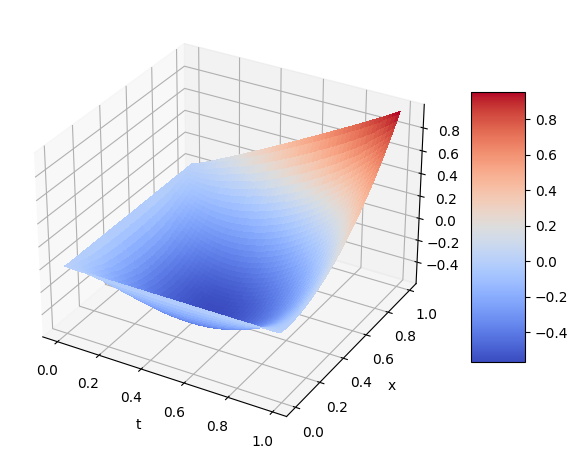

In [4]:
sol.plot2d()